<a href="https://colab.research.google.com/github/Davikky/rptu-courses/blob/main/tightbinding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ssh_1d.py
# 1D tight-binding lattice (uniform or SSH) — student-guided edition

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ============================
# 👩‍🏫 Roadmap (read me once)
# 1) Build H for an open chain (SSH pattern of couplings)
# 2) Diagonalize → eigenvalues/eigenvectors (what are the modes?)
# 3) Time/propagation evolution: i dψ/dz = H ψ  (we integrate with solve_ivp)
# 4) Visualize: spectrum, diffraction fan, selected-site traces, probability check
# 5) Compare bulk Bloch bands (periodic) vs finite-chain spectrum (edge physics)
# ============================

In [4]:
# ----------------------------
# Hamiltonian builder (SSH; open boundaries)
# ----------------------------
def makeH_1D_SSH(N, j1, j2, beta):
    """
    Minimal 1D chain Hamiltonian with alternating couplings (open boundary).
      N    : number of sites
      j1   : bonds (1-2), (3-4), ...
      j2   : bonds (2-3), (4-5), ...
      beta : on-site term (same on all sites)
    """
    H = beta * np.eye(N, dtype=complex)

    # Tip: 'off' stores all nearest-neighbor couplings; we then put them on ±1 diagonals.
    off = np.zeros(N - 1, dtype=complex)
    off[0::2] = j1  # odd bonds: (1-2), (3-4), ...
    off[1::2] = j2  # even bonds: (2-3), (4-5), ...

    # Hermitian SSH Hamiltonian (no magnetic phases here → conjugate is redundant if j are real)
    H += np.diag(off, k=+1) + np.diag(np.conjugate(off), k=-1)
    return H

In [5]:
# ----------------------------
# Bulk Bloch bands (periodic SSH, 2-site unit cell)
# ----------------------------
def plot_bloch_bands(j1, j2, beta0):
    # Working theory: in k-space the SSH dispersion is β(k)=β0 ± sqrt(j1^2 + j2^2 + 2 j1 j2 cos k)
    k = np.linspace(-np.pi, np.pi, 400)
    rad = np.sqrt(j1**2 + j2**2 + 2*j1*j2*np.cos(k))

    plt.figure(figsize=(6,4), facecolor='w')
    plt.plot(k, beta0 - rad, linewidth=2, label='lower band')
    plt.plot(k, beta0 + rad, linewidth=2, label='upper band')
    plt.axhline(beta0, color='k', ls=':', linewidth=1)
    plt.xlabel('k')
    plt.ylabel(r'$\beta(k)$')
    plt.title(fr'Periodic SSH bulk bands  ($j_1={j1:.3g}$, $j_2={j2:.3g}$)')
    plt.grid(True); plt.legend(); plt.tight_layout()

    # ✅ Check yourself:
    # - When j1 = j2, do the two bands touch at k=±π? (Gap closes → uniform chain)
    # - Increasing |j2 - j1| should open a gap. Do you see it?


In [6]:
# ----------------------------
# Finite-chain spectrum vs j1 (edge states live here)
# ----------------------------
def plot_finite_sweep(j1_min, j1_max, j2, beta0, N, num=200):
    j1_vec = np.linspace(j1_min, j1_max, num)
    evals  = np.zeros((N, num))
    for s, j1 in enumerate(j1_vec):
        H = makeH_1D_SSH(N, j1, j2, beta0)
        evals[:, s] = np.sort(np.linalg.eigvalsh(H).real)

    plt.figure(figsize=(6.6,4.2), facecolor='w')
    plt.plot(j1_vec, evals.T, 'k', lw=1)
    plt.axvline(j2, color='r', ls='--', alpha=0.7, label=r'gap closing ($j_1=j_2$)')
    plt.xlabel(r'$j_1$'); plt.ylabel(r'$\beta$')
    plt.title(fr'Finite-chain SSH spectrum ($j_2={j2:.2f}$, $N={N}$)')
    plt.grid(True); plt.legend(loc='best'); plt.tight_layout()

    # ✅ Check yourself:
    # - For j1 < j2 (one topological sector), do you spot nearly mid-gap eigenvalues?
    # - Do those disappear as j1 → j2 and swap to the other side for j1 > j2?


In [7]:
# ----------------------------
# Parameters (tweak these)
# ----------------------------
N     = 100      # number of sites (use 40–60 for faster sweeps during testing)
j1    = 0.1      # intra-cell (try 0.1)
j2    = 1.0      # inter-cell (try 1.0) — sets topological phase relative to j1
beta0 = 0.0      # uniform on-site term (nonzero shifts the whole spectrum)

In [8]:
# ----------------------------
# Build H (no hard-coded matrices)
# ----------------------------
H_phys = makeH_1D_SSH(N, j1, j2, beta0)

# 🎯 Concept ping:
# Q1: Why are couplings off-diagonal? → Because hopping connects neighboring sites.
# Q2: What does beta0 change physically? → A uniform refractive-index (energy) shift.

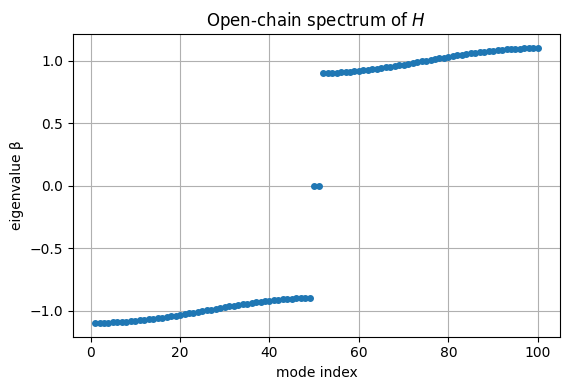

In [9]:
# ----------------------------
# Diagonalization (eigenvalues/vectors)
# ----------------------------
eigs, V = np.linalg.eigh(H_phys)     # Hermitian → real eigenvalues
idx     = np.argsort(eigs)
eigs    = eigs[idx]
V       = V[:, idx]

plt.figure(figsize=(5.8,4.0), facecolor='w')
plt.plot(np.arange(1, N+1), eigs, 'o', ms=4)
plt.xlabel('mode index'); plt.ylabel('eigenvalue β')
plt.title(r'Open-chain spectrum of $H$')
plt.grid(True); plt.tight_layout()

# ✅ Check yourself:
# Q3: For j1=j2 and beta0=0, the chain is uniform. Expect a cosine-like band (no gap).
# Q4: For j1≠j2, a gap opens. Edge-localized modes can appear ~at β≈β0.


In [10]:
# ----------------------------
# Time/propagation evolution:  i dψ/dz = H ψ
# We integrate dψ/dz = -i H ψ
# ----------------------------
def rhs(z, psi):
    return -1j * (H_phys @ psi)

# Launch state: single-site excitation
psi0 = np.zeros(N, dtype=complex)
center_idx = (N - 1) // 2  # center-ish for any N
psi0[center_idx] = 1.0

zmax  = 20.0
zgrid = np.linspace(0.0, zmax, 800)

sol = solve_ivp(rhs, (0.0, zmax), psi0, t_eval=zgrid, method='RK45',
                rtol=1e-10, atol=1e-12)

Z   = sol.t
PSI = sol.y.T                 # shape (#z, N)
I   = np.abs(PSI.T)**2        # N x #z

# ✅ Check yourself:
# Q5: Why -i? → Schrödinger-type evolution is unitary: U=exp(-iHz).
# Q6: How many ODEs? → N complex ODEs (i.e., 2N real ones).

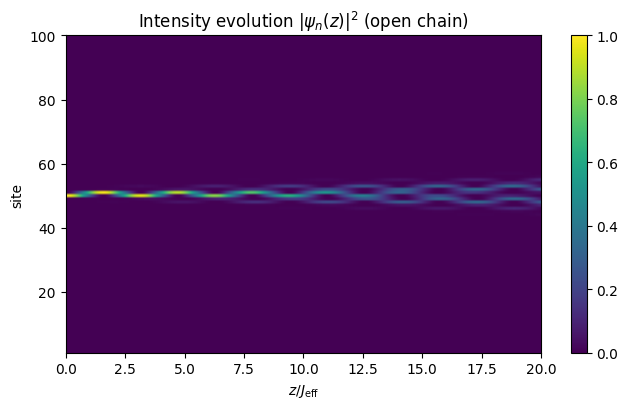

In [11]:
# ----------------------------
# Heatmap: diffraction fan / edge trapping
# ----------------------------
J_eff = max(abs(j1), abs(j2)) if (j1 != 0 or j2 != 0) else 1.0

plt.figure(figsize=(6.8,4.2), facecolor='w')
plt.imshow(I, aspect='auto', origin='lower',
           extent=[Z[0]*J_eff, Z[-1]*J_eff, 1, N])
plt.colorbar()
plt.xlabel(r'$z / J_{\mathrm{eff}}$'); plt.ylabel('site')
plt.title(r'Intensity evolution $|\psi_n(z)|^2$ (open chain)')
plt.tight_layout()

# ✅ Check yourself:
# Q7: Why plot |ψ|^2? → That’s measurable intensity/probability.
# Q8: Should sum_n |ψ_n|^2 be constant? → Yes, unitary evolution conserves norm.


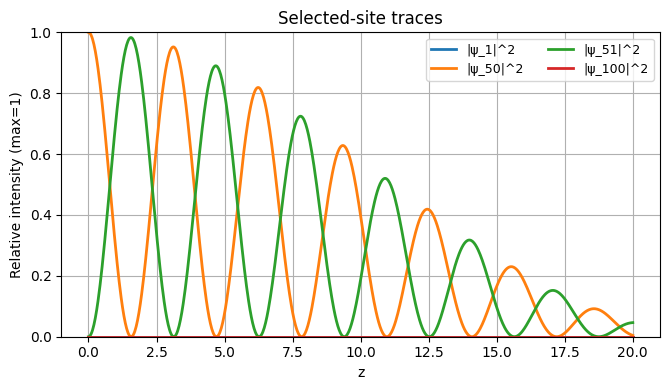

In [12]:
# ----------------------------
# Selected sites (normalized to global max = 1)
# ----------------------------
I_norm = I / np.max(I)

# Choose a few informative sites only (avoid spaghetti):
sites_to_plot = [0, center_idx, min(center_idx+1, N-1), N-1]  # edge, center, neighbor, far edge
labels = [f'|ψ_{s+1}|^2' for s in sites_to_plot]

plt.figure(figsize=(6.8,4.0), facecolor='w')
for s, lab in zip(sites_to_plot, labels):
    plt.plot(Z, I_norm[s, :], lw=2, label=lab)
plt.xlabel('z'); plt.ylabel('Relative intensity (max=1)')
plt.title('Selected-site traces')
plt.ylim(0, 1); plt.grid(True); plt.legend(ncol=2, fontsize=9)
plt.tight_layout()

# ✅ Check yourself:
# Q9: For a center launch in a uniform chain, why is the pattern mirror-symmetric?
# Q10: Switch launch to site 1 (an edge). In the topological phase, does it stay localized?


[Conservation] Mean(total) = 1.000000
[Conservation] Max |total-1| = 1.37e-09


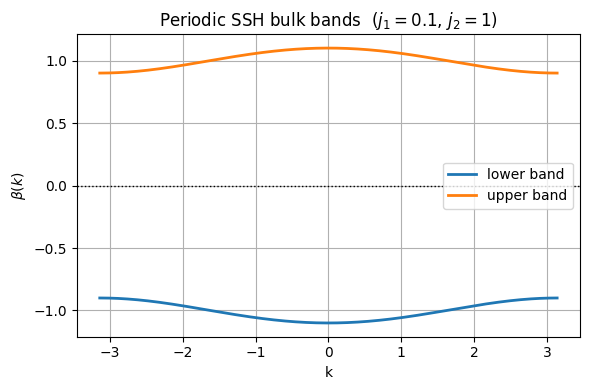

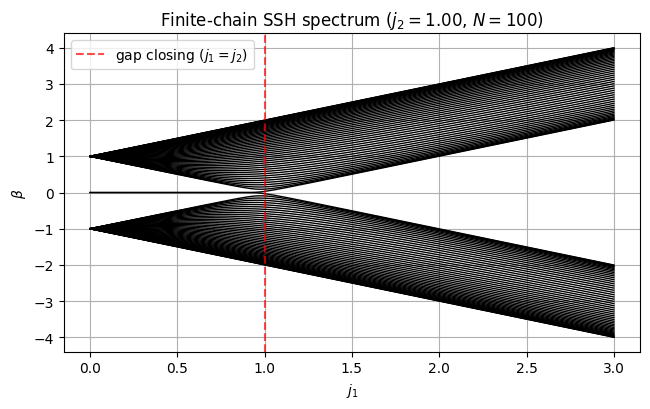

In [13]:
# ----------------------------
# Probability conservation (sanity check)
# ----------------------------
total = np.sum(I, axis=0)
print(f"[Conservation] Mean(total) = {np.mean(total):.6f}")
print(f"[Conservation] Max |total-1| = {np.max(np.abs(total - 1)):.2e}")

# ✅ Check yourself:
# Q11: If total drifts < 1, what’s missing? → Loss. How would you add it? → Im(β)<0 on diagonal.

# ----------------------------
# Bulk vs finite: where does topology show?
# ----------------------------
plot_bloch_bands(j1, j2, beta0)
plot_finite_sweep(j1_min=0.0, j1_max=max(3*j2, 1.0), j2=j2, beta0=beta0, N=N, num=200)

plt.show()


In [ ]:
# ============================
# 🧪 Try-this ideas (quick edits)
# - Flip (j1, j2): swap topological/trivial. Edge modes migrate sides.
# - Set beta0 ≠ 0: spectrum shifts; edge modes still sit in the gap relative to β0.
# - Add weak disorder: j1*(1+ε_n), j2*(1+ε_n). Do edge states survive?
# - Losses: H -> H - i*γ*I or site-dependent γ_n to explore non-Hermitian effects.
# - Different launches: Gaussian over sites instead of delta at one site.
# ============================